# 02_correlation_analysis.ipynb

전처리 산출물(Parquet)을 로드해 기술통계·분포(히스토그램), Spearman 상관(ρ)과 FDR 보정(p_fdr)을 계산/시각화합니다. 결과 표·그림은 results/에 저장합니다. (데이터 비공개)

셀 1 — 로드/컬럼 정리

In [1]:
# TL;DR: processed_weekly.parquet 로드 → 통계/히스토그램/스피어만(FDR) → 저장
import pyarrow.parquet as pq
import pandas as pd

PARQUET_IN = "results/tables/processed_weekly.parquet"
df = pq.read_table(PARQUET_IN).to_pandas()

# 라벨 편의: '.' → '_'
df.columns = [c.replace('.', '_') for c in df.columns]

셀 2 — 기술통계(+중앙값) & 히스토그램(샘플링)

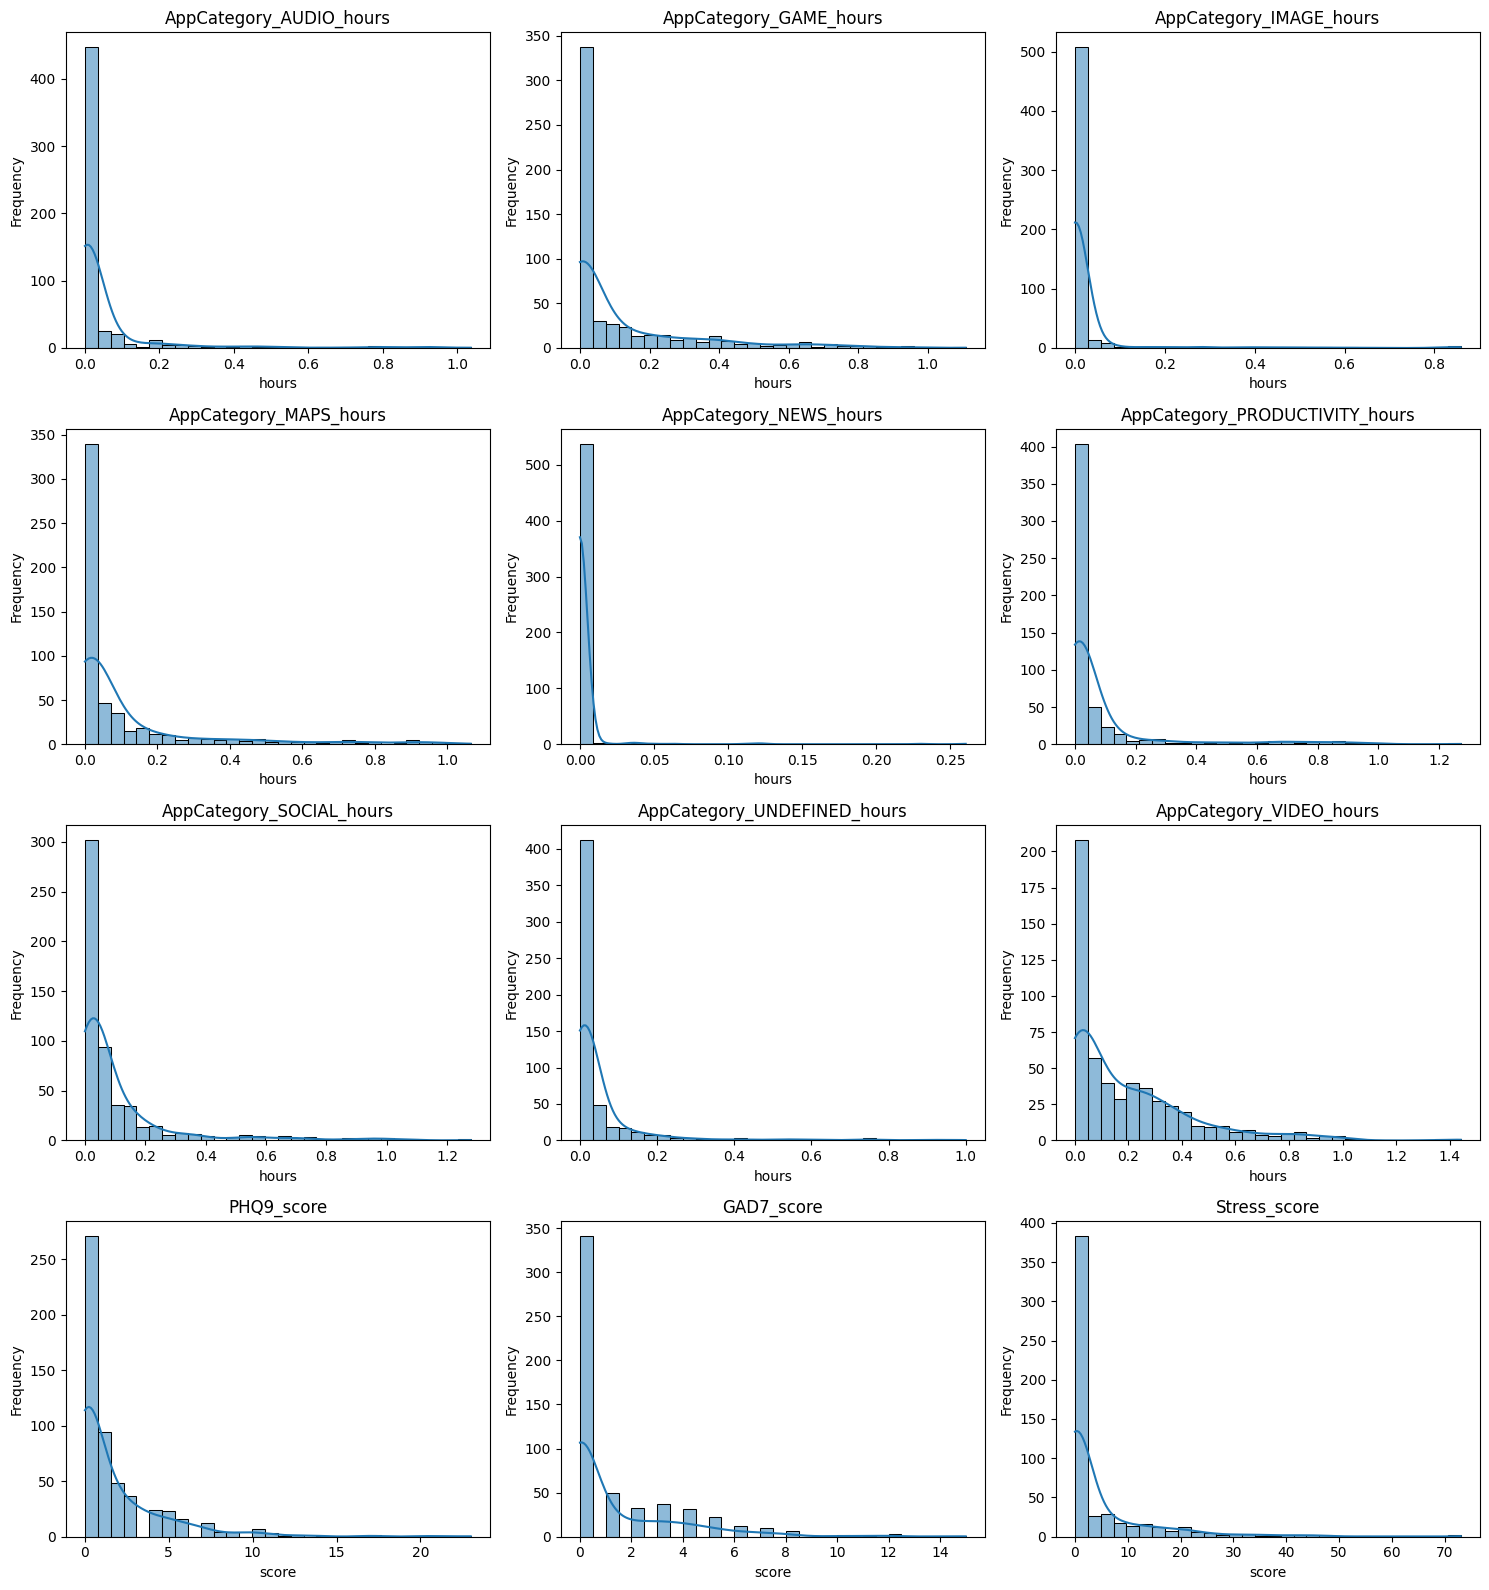

In [2]:
import numpy as np, matplotlib.pyplot as plt, seaborn as sns
from pathlib import Path
Path("results/figures").mkdir(parents=True, exist_ok=True)
Path("results/tables").mkdir(parents=True, exist_ok=True)

num_df = df.select_dtypes("number").copy()
cols = [c for c in num_df.columns if c.endswith("_hours")] + ["PHQ9_score","GAD7_score","Stress_score"]

# 기술통계(+median)
desc = num_df[cols].describe().T
desc["median"] = num_df[cols].median()
desc.to_csv("results/tables/descriptive_stats.csv")

# 대용량 안전: 샘플링
plot_df = num_df.sample(frac=0.3, random_state=42) if len(num_df) > 20000 else num_df

# 히스토그램 패널
n=len(cols); ncol=3; nrow=int(np.ceil(n/ncol))
plt.figure(figsize=(15,4*nrow))
for i,c in enumerate(cols,1):
    plt.subplot(nrow,ncol,i)
    sns.histplot(plot_df[c].dropna(), kde=True, bins=30)
    plt.title(c); plt.xlabel("hours" if c.endswith("_hours") else "score"); plt.ylabel("Frequency")
plt.tight_layout(); plt.savefig("results/figures/dist_panels.png", dpi=180); plt.show()


셀 3 — Spearman 상관 + FDR 보정 + 히트맵

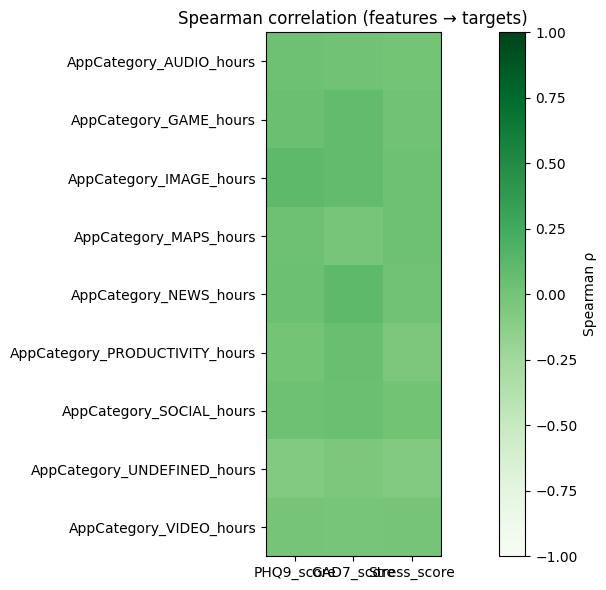

In [3]:
from scipy.stats import spearmanr
from statsmodels.stats.multitest import multipletests
import pandas as pd, numpy as np, matplotlib.pyplot as plt

X = [c for c in df.columns if c.endswith("_hours")]
Y = ["PHQ9_score","GAD7_score","Stress_score"]

pairs, rhos, pvals = [], [], []
for cx in X:
    for cy in Y:
        r, p = spearmanr(df[cx], df[cy], nan_policy="omit")
        pairs.append((cx,cy)); rhos.append(r); pvals.append(p)

rej, p_fdr, _, _ = multipletests(pvals, method="fdr_bh", alpha=0.05)
out = pd.DataFrame({"feature":[a for a,b in pairs],
                    "target":[b for a,b in pairs],
                    "rho":rhos,"p_raw":pvals,"p_fdr":p_fdr,"sig_fdr":rej})
out.sort_values(["target","p_fdr"]).to_csv("results/tables/spearman_fdr.csv", index=False)

# 히트맵(ρ)
rho_mat = pd.DataFrame(index=X, columns=Y, dtype=float)
for (cx,cy), r in zip(pairs, rhos):
    rho_mat.loc[cx,cy] = r

plt.figure(figsize=(12,6))
plt.imshow(rho_mat.values.astype(float), cmap="Greens", vmin=-1, vmax=1)
plt.colorbar(label="Spearman ρ")
plt.xticks(range(len(Y)), Y); plt.yticks(range(len(X)), X)
plt.title("Spearman correlation (features → targets)")
plt.tight_layout(); plt.savefig("results/figures/spearman_heatmap.png", dpi=180); plt.show()


In [5]:
# 02: hypothesis-driven FDR (subset only)
import pandas as pd
from scipy.stats import spearmanr
from statsmodels.stats.multitest import multipletests

subset_X = [c for c in df.columns if c in [
    "AppCategory_SOCIAL_hours","AppCategory_GAME_hours",
    "AppCategory_VIDEO_hours","AppCategory_PRODUCTIVITY_hours"
]]
subset_Y = [c for c in ["PHQ9_score","GAD7_score","Stress_score"] if c in df.columns]

pairs, rhos, pvals = [], [], []
for x in subset_X:
    for y in subset_Y:
        r, p = spearmanr(df[x], df[y], nan_policy="omit")
        pairs.append((x,y)); rhos.append(r); pvals.append(p)

rej, p_fdr, _, _ = multipletests(pvals, method="fdr_bh", alpha=0.05)
out_h = pd.DataFrame({"feature":[a for a,b in pairs],"target":[b for a,b in pairs],
                      "rho":rhos,"p_raw":pvals,"p_fdr":p_fdr,"sig_fdr":rej})
out_h.to_csv("results/tables/spearman_fdr_hypotheses.csv", index=False)
print("→ saved results/tables/spearman_fdr_hypotheses.csv")


→ saved results/tables/spearman_fdr_hypotheses.csv


In [7]:
# 02: exploratory (uncorrected) top-5 by |rho|
expl = pd.read_csv("results/tables/spearman_fdr.csv")
expl["abs_rho"] = expl["rho"].abs()
expl_top = (expl.sort_values(["target","abs_rho"], ascending=[True, False])
                 .groupby("target").head(5))
expl_top.to_csv("results/tables/spearman_exploratory_top.csv", index=False)
print("→ saved results/tables/spearman_exploratory_top.csv")


→ saved results/tables/spearman_exploratory_top.csv
